In [92]:
!pip install langgraph
!pip install langchain-openai
!pip install langchain_community
!pip install langchain tavily-python
!pip install langgraph-checkpoint-sqlite
!pip install aiosqlite

In [74]:
import os
from getpass import getpass
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

In [75]:
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass("🔐 Enter your Tavily API key: ")

In [76]:
import langgraph
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain.tools.tavily_search import TavilySearchResults

In [77]:
''' We will use the `TavilySearchResults` tool to perform real-time web searches.'''

tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [78]:
''' Defining an agent state 
    - To track full conversation history
    - Automatically merge messages across steps (e.g., LLM → tool → LLM)
    - Used by every node in the LangGraph to get/update the state'''

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [79]:
''' Setting up checkpointing for a LangGraph agent using SQLite.
Enables the agent to save and restore state during execution.'''

from langgraph.checkpoint.sqlite import SqliteSaver

In [80]:
''' Defining an AI agent that:

- Uses a language model to generate thoughts and actions.

- Executes actions (i.e. tools) if requested by the model.

- Loops back with the results (observations) to inform the final answer.


exists_action(self, state)
- Checks if the latest LLM message contains tool calls.
- Used to decide whether to run action or end the graph

call_openai(self, state)
- Sends all accumulated messages to the LLM, including an optional system prompt.
- Returns the assistant’s next message.

take_action(self, state)
- Executes tools requested by the LLM:
- Iterates over tool_calls
- Looks up each tool by name
- Invokes it with the provided args-
- Returns the results as ToolMessages


'''

class Agent:

    def __init__(self, model, tools,checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(checkpointer=checkpointer) #checkpointer=checkpointer: Adds persistence—the ability to save and restore execution state using the specified checkpointer (e.g., a SqliteSaver object).
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [81]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost


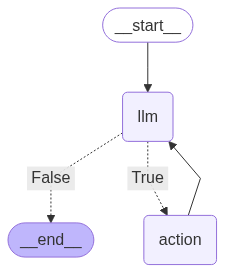

In [82]:
from IPython.display import Image, display

display(Image(abot.graph.get_graph().draw_mermaid_png()))

In [89]:
import atexit

# ✅ Manually enter the context to open the database
saver_context = SqliteSaver.from_conn_string("state.db")
memory = saver_context.__enter__()  # get actual saver

# ✅ Register proper closing at Python shutdown
atexit.register(lambda: saver_context.__exit__(None, None, None))  # close when done

''' Using stream method to get all intermediate messages
'''

abot = Agent(model, [tool], system=prompt, checkpointer=memory)
    
messages = [HumanMessage(content="What is the weather in sf?")]
   
# Define a unique thread/session ID to track this conversation across agent steps and enable checkpointing
thread = {"configurable": {"thread_id": "1"}}
    
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v["messages"]) 

[AIMessage(content='The current weather in San Francisco is mostly sunny with a high of 65°F. If you need more details or have any other questions about the weather in San Francisco, feel free to ask!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 13887, 'total_tokens': 13927, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C0yIKdqvj00oy0y7FSuON1OiFXf77', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--5e681a0b-ded8-4dc8-afd7-baff5a94be7a-0', usage_metadata={'input_tokens': 13887, 'output_tokens': 40, 'total_tokens': 13927, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]


In [84]:
#We have now established persistence with the checkpointer
# When asked about la the agent knows that we are asking for the weather. We pass in the same thread id as for df

messages = [HumanMessage(content="What about in la?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DAaa0kf4HfcISX7k6yKKfTRE', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 12150, 'total_tokens': 12172, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C0y5d6yYxMpJ4gzyzRX63OZkYy1bB', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fdcbdf3d-bae9-4d88-8e1d-b906cfda0cca-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_DAaa0kf4HfcISX7k6yKKfTRE', 'type': 'tool_call'}], usage_metadata={'inpu

In [61]:
messages = [HumanMessage(content="Which one is warmer?")]
thread = {"configurable": {"thread_id": "1"}} #If we do not pass in thread id the agent will not have access to any history
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Uo36mG2EDG4BNI8p9vS1BntY', 'function': {'arguments': '{"query": "current temperature in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_CoQdai07wVXnuA1euu6oLBC1', 'function': {'arguments': '{"query": "current temperature in Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 7259, 'total_tokens': 7318, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C0acW5Gc4qGlKxQ4Qf5xJh9rfH203', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d4aba9a9-2a67-4f96-9698-407ca38a5d79-0', tool_

In [85]:
## Streaming tokens

In [103]:
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

async with AsyncSqliteSaver.from_conn_string("state.db") as memory:
    thread = {"configurable": {"thread_id": "4"}}
    
    abot = Agent(model, [tool], system=prompt, checkpointer=memory)
    
    messages = [HumanMessage(content="What is the weather in SF?")]
    async for event in abot.graph.astream_events({"messages": messages}, thread, version="v1"):
        kind = event["event"]
        if kind == "on_chat_model_stream":
            content = event["data"]["chunk"].content
            if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
                print(content, end="|")


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_zZNNJ9vvOjgd2ftoHYFY4CCi', 'type': 'tool_call'}
Back to the model!
I| found| some| sources| that| provide| information| on| the| current| weather| in| San| Francisco|:

|1|.| **|San| Francisco|,| CA| Weather| Forecast| -| Acc|u|Weather|**:| This| site| offers| a| detailed| weather| forecast| for| San| Francisco|,| including| information| on| today|'s| weather|,| current| weather| conditions|,| hourly| weather| updates|,| and| a| |10|-day| weather| forecast|.

|2|.| **|San| Francisco| weather| in| August| |202|5| || Weather|25|.com|**:| This| source| provides| temperature| details|,| rainy| days|,| dry| days|,| and| other| weather|-related| information| for| San| Francisco| in| August| |202|5|.

|3|.| **|Current| Weather| -| San| Francisco|,| CA| -| Acc|u|Weather|**:| This| source| gives| specific| details| such| as| wind| gust|s|,| probability| of| precipitation|,| cloud| 